# Bayesian Optimization for QCBED

In this notebook, we try to write a "simple" Bayesian optimization program and check, whether it works. For that, we need
- an objective function $f$
    - this is what we want to optimize
    - querying the objective function is expensive, so we want to do this rarely
- a probabilistic model, in this case a Gaussian Process regressor, as a surrogate for the objective function
    - we use the surrogate model to determine which points to best query next
- an acquisition function that decides which point to query next
    - based on the surrogate function and our current sample, the acquisition function finds the next query point
    - there is usually a trade-off parameter between exploration and exploitation that determines the behavior
    - high exploration means the acquisition function tries to map f well with little regard for finding the optimum
    - high exploitation means the acquisition function is mostly concerned with minimizing whatever it has already learned about if. This will often lead to it greadily finding a local optimum in the vicinity of initial samples.


In [219]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(41)

### The objective function

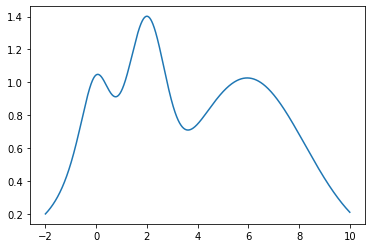

In [220]:
def f(x): #in a next step, we could also be looking at having a function with noise, but right now I will leave it.
    return np.exp(-(x - 2) ** 2) + np.exp(-(x - 6) ** 2 / 10) + 1/ (x ** 2 + 1)

x = np.linspace(-2, 10, 10000)
plt.plot(x,f(x))
plt.show()

### The Gaussian Process (GP) Regressor
I will add an implementation of this afterwards, but let's start by using an existing implementation.

In [221]:
from sklearn.gaussian_process import GaussianProcessRegressor as GP
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

### Let's try our own GP Regressor

In [222]:
class GaussianKernel:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def __call__(self, X, Z):
        Xsq_sum = np.sum(X**2, axis = 1).reshape(-1,1)
        Zsq_sum = np.sum(Z**2, axis = 1)
        squared_dist = Xsq_sum + Zsq_sum - 2* np.dot(X, Z.T)
        return np.exp( (-1/(2*self.sigma)) * squared_dist )

class GPR:
    def __init__(self, kernel, var=1e-6):
        self.kernel = kernel
        self.var = var
    
    def fit(self, X,y):
        self.Xtrain = X
        self.y = y
        K = self.kernel(X,X)
        self.L = np.linalg.cholesky(K + self.var*np.eye(X.shape[0]))
                                   
    def predict(self, X, return_std=True):
        LK = np.linalg.solve(self.L, self.kernel(self.Xtrain, X))
        mu = np.dot(LK.T, np.linalg.solve(self.L, self.y))
        Kpredict = self.kernel(X,X)
        std = np.sqrt(np.diag(Kpredict) - np.sum(LK**2, axis=0))
        if return_std:
            return mu, std
        else:
            return mu

# Let us compare our GP Regression to the sklearn one

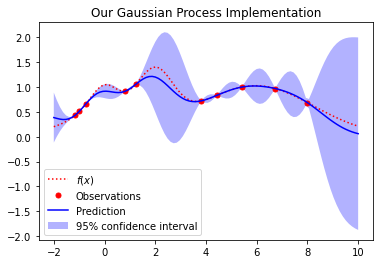

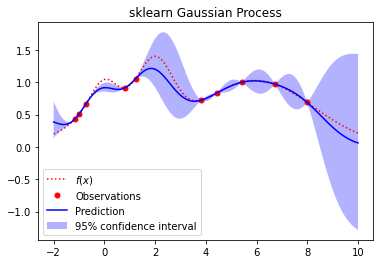

In [224]:
# Let us plot the surrogate trained on a small sample and compare it to the true function f
n = 10
Xsample = (np.random.rand(n)*10 - 2).reshape(-1, 1) #random sample from [-2,10]
Ysample = f(Xsample)

#one clear advantage is that sklearn has parameter evaluation implemented and uses regularization
sklearnKernel = C(100, (1e-3, 1e3)) * RBF(100, (1e-3, 1e3))
sklearnModel = GP(kernel=sklearnKernel, n_restarts_optimizer=9)
sklearnModel.fit(Xsample, Ysample)

#I found the sigma parameter for the kernel by trial and error... :D
kernel = GaussianKernel(1e-0)
model = GPR(kernel)
model.fit(Xsample,Ysample)

#plot the GP model:
x = np.linspace(-2, 10, 100)
y = f(x)

y_pred, sigma = model.predict(x.reshape(-1, 1))
y_predSklearn, sigmaSklearn = sklearnModel.predict(x.reshape(-1, 1), return_std=True)

plt.figure()
plt.title("Our Gaussian Process Implementation")
plt.plot(x, f(x), 'r:', label=r'$f(x)$')
plt.plot(Xsample, Ysample, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x, y_pred.reshape(-1) - 1.9600 * sigma, y_pred.reshape(-1) + 1.9600 * sigma, 
                 label='95% confidence interval', facecolor='blue', alpha=0.3)
plt.legend()
plt.show()

plt.figure()
plt.title("sklearn Gaussian Process")
plt.plot(x, f(x), 'r:', label=r'$f(x)$')
plt.plot(Xsample, Ysample, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x, y_predSklearn.reshape(-1) - 1.9600 * sigmaSklearn, y_predSklearn.reshape(-1) + 1.9600 * sigmaSklearn, 
                 label='95% confidence interval', facecolor='blue', alpha=0.3)
plt.legend()
plt.show()

I think it is fair to conclude that our own GP implementation is close enough to the sklearn one. So let's use our own implementation from now on.

### The surrogate function

In [210]:
def surrogate(model, X):
    return model.predict(X, return_std=True) #we need the prediction and uncertainty, here

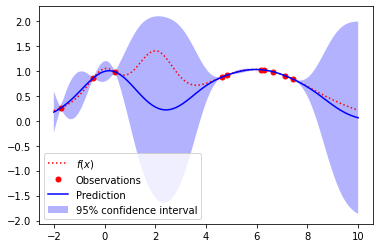

In [225]:
# Let us plot the surrogate trained on a small sample and compare it to the true function f
n = 10
Xsample = (np.random.rand(n)*10 - 2).reshape(-1, 1) #random sample from [-2,10]
Ysample = f(Xsample)

#use the following two lines to use the sklearn Gaussian Process Regression
#kernel = C(100, (1e-3, 1e3)) * RBF(100, (1e-3, 1e3))
#model = GP(kernel=kernel, n_restarts_optimizer=9)

#use the following two lines to use the GP implementation above
kernel = GaussianKernel(1e-0)
model = GPR(kernel)


model.fit(Xsample,Ysample)

#plot the GP model:
x = np.linspace(-2, 10, 100)
y = f(x)
y_pred, sigma = surrogate(model, x.reshape(-1, 1))

plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x)$')
plt.plot(Xsample, Ysample, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x, y_pred.reshape(-1) - 1.9600 * sigma, y_pred.reshape(-1) + 1.9600 * sigma, 
                 label='95% confidence interval', facecolor='blue', alpha=0.3)
plt.legend()
plt.show()

### The acquisition function

The acquisition function consists of two parts. A search strategy over the surrogate function and a scoring for each point. The scoring is mostly determined by the exploration-exploitation trade-off. The search strategy can be made intelligently, using some optimization, but it also works with a simple grid-search or a random search. In the following, I will implement a simple grid search. For high-dimension problems, it will definitely be worthwhile implementing a better search strategy.

In [226]:
#search strategy:
class random_search: #I use a bit of object orientation here to reduce the number of parameters... 
    def __init__(self, n, domain):
        self.n = n
        self.domain = domain #domain is a list [a,b]
    
    def __call__(self, X,Y,model): #returns n points from the domain [a,b]
        Xsamples = np.random.rand(self.n)*(self.domain[1] - self.domain[0]) + self.domain[0] #n values in [a,b]
        return Xsamples

#scoring function
from scipy.stats import norm #here we use the cdf of the normal distribution

def probability_of_improvement(Xcand, X, model):
    y_pred, _ = surrogate(model, X)
    currOpt = max(y_pred)
    mu, std = surrogate(model, Xcand.reshape(-1,1))
    if len(mu.shape) == 2:
        mu = mu[:,0]
    #probability of improvement:
    probs = norm.cdf((mu - currOpt) / (std+1E-9)) #the small additive term is just for numerical stability if std = 0
    return probs


def acquisition_function(X,Y,model, search_strategy=random_search(100, [-2,10]), scoring=probability_of_improvement):
    Xcand = search_strategy(X,Y,model)
    scores = scoring(Xcand, X, model)
    idx = np.argmax(scores)
    return Xcand[idx]

### Complete Bayesian Optimization

Now we put together the building blocks to form our Bayesian optimization algorithm.

In [227]:
def bayesian_optimization(X, Y, n, model): #performs n steps of Bayesian optimization and returns the optimum
    for i in range(n):
        x = acquisition_function(X, Y, model)
        #evaluate the objective function at that point
        y_true = f(x)
        #obtain prediction of the surrogate for this point to compare it to the true value
        est, _ = surrogate(model, [[x]])
        print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, y_true))
        #add the new point to the set of samples
        X = np.vstack((X, [[x]]))
        Y = np.vstack((Y, [[y_true]]))
        #update the model
        model.fit(X, Y)
    idx = np.argmax(Y)
    return X[idx], Y[idx], X, Y

## Let's try it out...

In [228]:
n = 2 #size of the initial sample
Xsample = (np.random.rand(n)*10 - 2).reshape(-1, 1) #random sample from [-2,10]
Ysample = f(Xsample)
kernel = C(100, (1e-3, 1e3)) * RBF(100, (1e-3, 1e3))
model = GP(kernel=kernel, n_restarts_optimizer=9)

optX, optY, X, Y = bayesian_optimization(Xsample.copy(), Ysample.copy(), 10, model)

>x=3.751, f()=0.000000, actual=0.716
>x=1.868, f()=1.375950, actual=1.387
>x=1.937, f()=1.403692, actual=1.398
>x=-0.410, f()=0.789629, actual=0.875
>x=4.853, f()=0.497169, actual=0.918
>x=6.186, f()=0.303742, actual=1.022
>x=1.955, f()=1.400067, actual=1.400
>x=7.435, f()=0.462862, actual=0.832
>x=1.960, f()=1.400413, actual=1.400
>x=8.931, f()=0.209963, actual=0.436


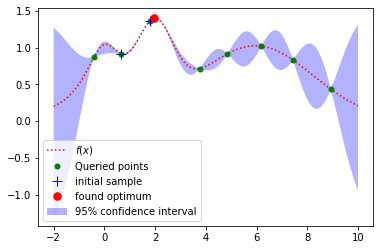

In [229]:
# and now, let's plot the results

x = np.linspace(-2, 10, 100)
y = f(x)
y_pred, sigma = surrogate(model, x.reshape(-1, 1))

plt.figure()
plt.plot(x, y, 'r:', label=r'$f(x)$')
plt.plot(X, Y, 'g.', markersize=10, label='Queried points')
plt.plot(Xsample, Ysample, 'b+', markersize=10, label="initial sample")
plt.plot(optX, optY, 'r.', markersize=15, label='found optimum')
plt.fill_between(x, y_pred.reshape(-1) - 1.9600 * sigma, y_pred.reshape(-1) + 1.9600 * sigma, 
                 label='95% confidence interval', facecolor='blue', alpha=0.3)
plt.legend()
plt.show()